In [1]:
from IPython.display import FileLink

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(dplyr); library(tidyr)
library(ggplot2)
library(phyloseq)
library(RColorBrewer)
library(gridExtra)
library(DESeq2)


Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: grid
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, intersect,
    is.uns

In [4]:
%%R
asNumeric = function(x) { as.numeric(as.character(x)) }

physeq = import_biom("data/otu_table_wtax.biom", "data/otusn.tree")
sample.data = import_qiime_sample_data("data/ABCD_combined_reads_mapper.tsv")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)

physeq.bulk = prune_samples((physeq.md$Treatment %in% c("12CCPS","13CCPS","12CCSS","13CCSS", "13CXPS"))& 
                            (physeq.md$Day %in% c(30)) &
                            row.names(physeq.md) %in% grep("bulk", 
                                                          row.names(physeq.md), 
                                                          value=TRUE), physeq)

physeq.bulk = filter_taxa(physeq.bulk, function(x) sum(x) > 0, prune = TRUE)

print(physeq.bulk)
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2192 taxa and 5 samples ]
sample_data() Sample Data:       [ 5 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 2192 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 2192 tips and 2191 internal nodes ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6236 taxa and 352 samples ]
sample_data() Sample Data:       [ 352 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 6236 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 6236 tips and 6235 internal nodes ]


In [5]:
%%R
md = sample_data(physeq.bulk)
md$amendment = factor(ifelse(md$Treatment %in% c("13CCSS", "12CCSS"), 
                             "Simple", 
                             "Complex"),
                      levels = c("Complex", "Simple"))
sample_data(physeq.bulk) = md

In [6]:
%%R
colnames(sample_data(physeq.bulk))

[1] "X.SampleID"           "BarcodeSequence"      "Day"                 
[4] "Density"              "LinkerPrimerSequence" "Treatment"           
[7] "Description"          "amendment"           


In [7]:
%%R
dds = phyloseq_to_deseq2(physeq.bulk, ~amendment)
dds = DESeq(dds, fitType = "local")

converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [22]:
%%R
FDR = 0.1
df.bulk = data.frame(results(dds, independentFiltering = FALSE)) %>%
    select(l2fc.bulk = log2FoldChange, pval.bulk = pvalue)
df.bulk$OTU = rownames(df.bulk)
df.bulk = df.bulk %>%
    mutate(padj.bulk = p.adjust(pval.bulk, method = "BH")) %>%
    arrange(padj.bulk)
df.bulk

       l2fc.bulk    pval.bulk      OTU    padj.bulk
1    -2.65371433 1.664749e-10    OTU.1 3.649130e-07
2    -2.35294142 9.124321e-05    OTU.6 1.000026e-01
3     1.76655943 2.449580e-04    OTU.7 1.789827e-01
4     1.77604398 1.196444e-03 OTU.1623 5.245212e-01
5     5.01462879 9.788447e-04  OTU.337 5.245212e-01
6     2.98663397 1.663368e-03  OTU.221 6.076838e-01
7    -2.10021480 2.024517e-03   OTU.78 6.339631e-01
8     2.29496931 2.852552e-03  OTU.155 7.815993e-01
9    -4.37275512 4.350138e-03  OTU.150 8.102887e-01
10   -4.27289737 5.544859e-03  OTU.253 8.102887e-01
11   -2.23560244 3.526724e-03    OTU.4 8.102887e-01
12    4.43185408 5.304630e-03  OTU.169 8.102887e-01
13    4.43185408 5.304630e-03 OTU.4393 8.102887e-01
14    2.46186046 3.864345e-03  OTU.137 8.102887e-01
15   -2.66403955 5.507147e-03   OTU.77 8.102887e-01
16    1.36822908 3.946242e-01 OTU.3574 8.199770e-01
17    1.37457004 3.927092e-01 OTU.4213 8.199770e-01
18    1.37457004 3.927092e-01 OTU.4547 8.199770e-01
19    1.0311

In [9]:
%%R
FDR = 0.10

df.bulk.sig = df.bulk %>%
    filter(padj.bulk <= FDR)
df.bulk.sig

  l2fc.bulk    pval.bulk   OTU   padj.bulk
1 -2.653714 1.664749e-10 OTU.1 3.64913e-07


Joining by: "OTU"


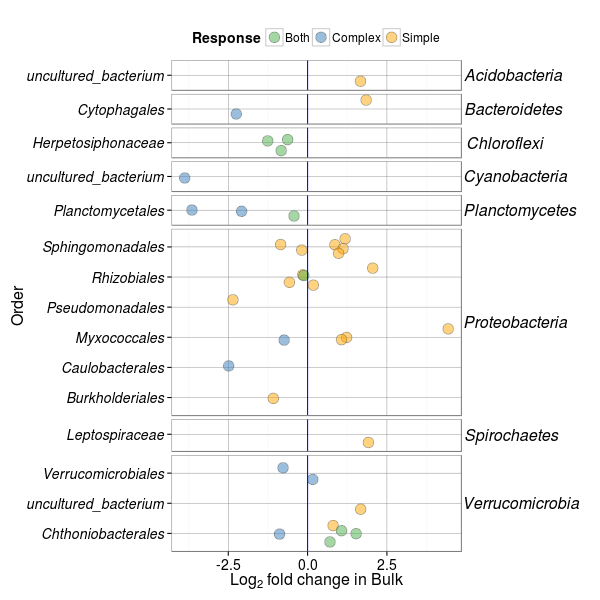

In [10]:
%%R -h 600 -w 600
FDR = 0.10

rspnse = function(x, t) {
    ifelse(length(x) == 2, "Both", ifelse(t == "13CCSS", 
                                          "Simple", 
                                          "Complex"))
}

df.rspnse = read.csv("data/l2fc_table.csv") %>%
    group_by(OTU, Treatment) %>%
    summarize(min.P = min(padj), 
              Rank2 = first(Rank2), 
              Rank4 = first(Rank4)) %>%
    filter(min.P <= FDR) %>%
    group_by(OTU) %>%
    summarize(rspnse = rspnse(min.P, Treatment), 
              Rank2 = first(Rank2),
              Rank4 = first(Rank4)) %>%
    left_join(df.bulk)

colours = c("#4daf4a", "#377eb8", "orange")

p = ggplot(df.rspnse, aes(y = Rank4, x = l2fc.bulk, fill = rspnse))

p = p + geom_point(size = 5, shape = 21, alpha = 0.5, position = position_jitter(h = 0.3, w = 0), color = "gray33")

p = p + facet_grid(Rank2 ~ ., scales = "free_y", space = "free")

p = p + geom_vline(xintercept = 0, color = "blue")

p = p + scale_fill_manual(values = colours, na.value = "black")

p = p + theme_bw()

p = p + labs(x = expression(paste(Log[2]," fold change in Bulk",sep="")), y = "Order", fill = "Response")

p = p + theme(axis.text.y = element_text(size = 14, face = "italic"),
              axis.text.x = element_text(size = 14), 
              axis.title = element_text(size = 16),
              strip.text.y = element_text(angle = 0, hjust = 0.1, size = 16, face = "italic"),
              strip.background = element_blank(),
              panel.grid.major = element_line(colour = "#808080"),
              legend.position = "top",
              legend.title = element_text(size = 14),
              legend.text = element_text(size = 12))

p.fc = p

p

In [11]:
%%R
ggsave("figs/l2fc.bulk_dotplotby_phylum.pdf", p.fc, h = 10, w = 8)

In [12]:
FileLink("figs/l2fc.bulk_dotplotby_phylum.pdf")

/home/ashley/single_substrate/figs/l2fc.bulk_dotplotby_phylum.pdf

In [13]:
%%R
ggsave("figs/l2fc.bulk_dotplotby_phylum.png", p.fc, h = 10, w = 8, dpi = 600)

In [14]:
FileLink("figs/l2fc.bulk_dotplotby_phylum.png")

/home/ashley/single_substrate/figs/l2fc.bulk_dotplotby_phylum.png

In [15]:
%%R 
FDR = 0.10

rspnse = function(x, t) {
    ifelse(length(x) == 2, "Both", ifelse(t == "13CCSS", 
                                          "Simple", 
                                          "Complex"))
}

df = read.csv("data/l2fc_table.csv") 

df.rspnse2 = df %>%
    group_by(OTU, Treatment) %>%
    summarize(min.P = min(padj), 
              Rank2 = first(Rank2), 
              Rank4 = first(Rank4)) %>%
    filter(min.P <= FDR) %>%
    group_by(OTU) %>%
    summarize(rspnse = rspnse(min.P, Treatment), 
              Rank2 = first(Rank2),
              Rank4 = first(Rank4)) %>%
    right_join(df)
#df.rspnse

df2 = df.rspnse2 %>%
    select(OTU, rspnse, Rank2, Rank4) %>%
    left_join(df.bulk)

df2$rspnse[is.na(df2$rspnse)] = "None"
df2

Joining by: c("OTU", "Rank2", "Rank4")
Joining by: "OTU"
Source: local data frame [1,198 x 7]

        OTU  rspnse         Rank2        Rank4   l2fc.bulk pval.bulk padj.bulk
1   OTU.783    None Acidobacteria      Sva0725          NA        NA        NA
2    OTU.79    None Bacteroidetes Cytophagales  0.21028320 0.7973409 0.9032927
3   OTU.304    None Bacteroidetes Cytophagales -0.01968188 0.9876232 0.9929477
4    OTU.50    None Bacteroidetes Cytophagales  0.07813965 0.9092922 0.9694400
5   OTU.382  Simple Bacteroidetes Cytophagales          NA        NA        NA
6   OTU.465 Complex Bacteroidetes Cytophagales -2.24659660 0.1952075 0.8199770
7   OTU.162    None Bacteroidetes Cytophagales  0.26871525 0.8241387 0.9195401
8  OTU.1084    None Bacteroidetes Cytophagales          NA        NA        NA
9   OTU.525  Simple Bacteroidetes Cytophagales  1.84563227 0.2739214 0.8199770
10  OTU.985    None Bacteroidetes Cytophagales          NA        NA        NA
..      ...     ...           ...   

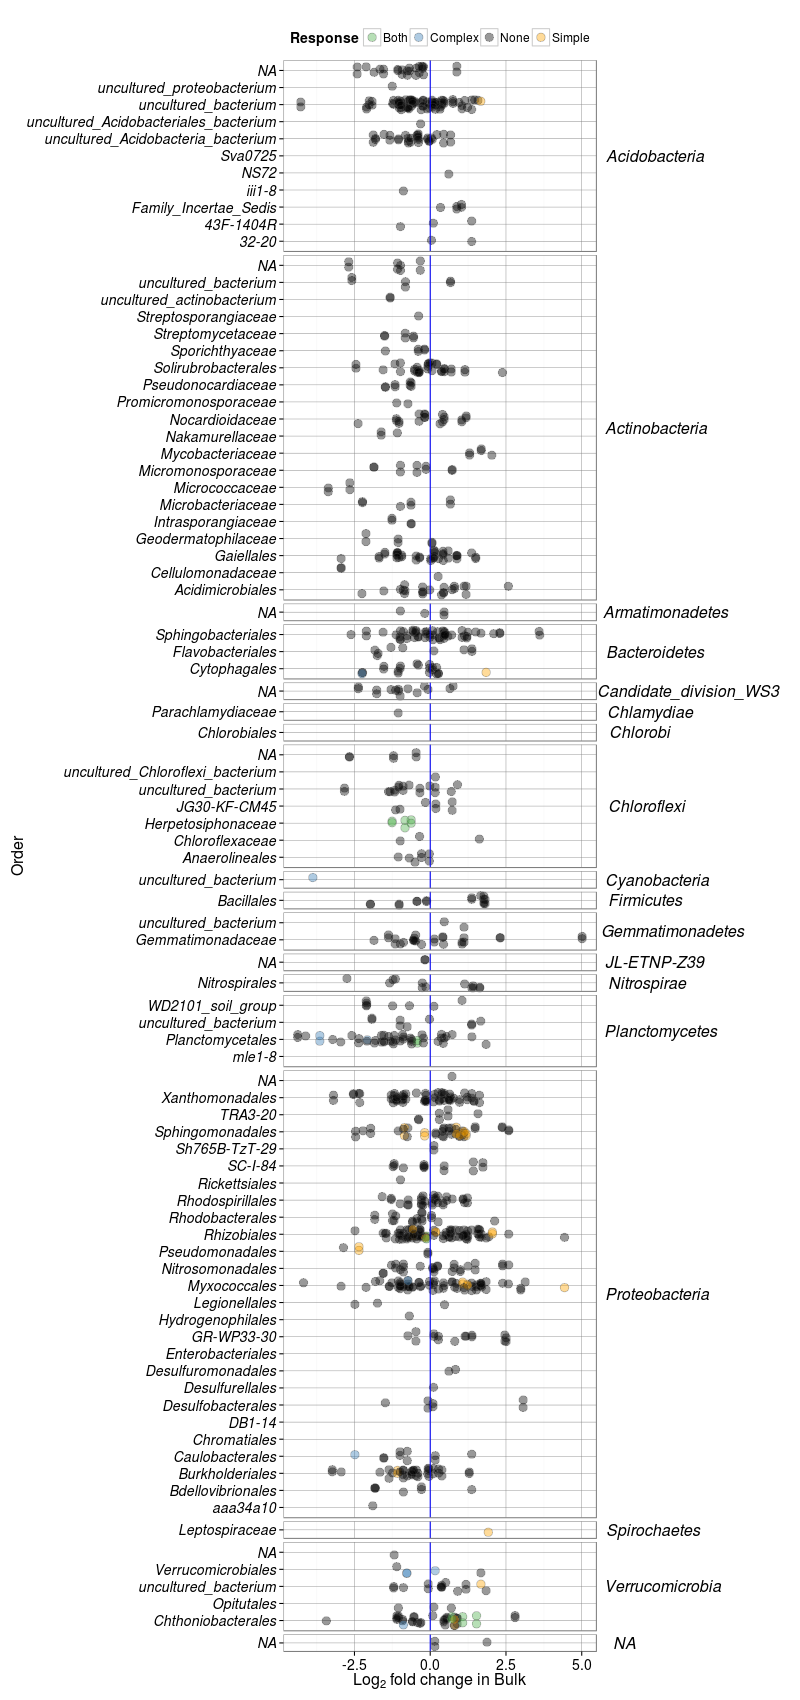

In [16]:
%%R -h 1700 -w 800

colours = c("#4daf4a", "#377eb8", "black", "orange")

p2 = ggplot(df2, aes(y = Rank4, x = l2fc.bulk, fill = rspnse))

p2 = p2 + geom_point(size = 4, shape = 21, alpha = 0.4, position = position_jitter(h = 0.3, w = 0), color = "gray33")

p2 = p2 + facet_grid(Rank2 ~ ., scales = "free_y", space = "free")

p2 = p2 + geom_vline(xintercept = 0, color = "blue")

p2 = p2 + scale_fill_manual(values = colours)
                           


p2 = p2 + theme_bw()

p2 = p2 + labs(x = expression(paste(Log[2]," fold change in Bulk",sep="")), y = "Order", fill = "Response")

p2 = p2 + theme(axis.text.y = element_text(size = 14, face = "italic"),
              axis.text.x = element_text(size = 14), 
              axis.title = element_text(size = 16),
              strip.text.y = element_text(angle = 0, hjust = 0.1, size = 16, face = "italic"),
              strip.background = element_blank(),
              panel.grid.major = element_line(colour = "#808080"),
              legend.position = "top",
              legend.title = element_text(size = 14),
              legend.text = element_text(size = 12))

p2

In [17]:
%%R
ggsave("figs/l2fc.bulk_w.NR_phylum.pdf", p2, h = 22, w = 10)

In [18]:
FileLink("figs/l2fc.bulk_w.NR_phylum.pdf")

/home/ashley/single_substrate/figs/l2fc.bulk_w.NR_phylum.pdf

In [19]:
%%R
ggsave("figs/l2fc.bulk_w.NR_phylum.png", p2, h = 20, w = 10)

In [20]:
FileLink("figs/l2fc.bulk_w.NR_phylum.png")

/home/ashley/single_substrate/figs/l2fc.bulk_w.NR_phylum.png